In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
n_train_events = 10
n_test_events = 2
n_events = n_train_events + n_test_events
event_outcomes = np.random.binomial(1, 0.5, n_events)

n_experts = 10
n_observations = n_events * n_experts
# use a Beta (2,2)
expert_accuracy = np.random.beta(2, 2, n_experts)

In [3]:
expert_event_df = pd.DataFrame(columns=['expert_id', 'event_id', 'expert_pred', 'true_outcome'],
                              index=np.arange(n_observations))
i = 0
for event_idx in range(n_events):    
    event_outcome = event_outcomes[event_idx]

    correct_pred = np.random.binomial(1, expert_accuracy)
    random_guess = np.random.binomial(1, 0.5 * np.ones(n_experts))

    event_pred = correct_pred * event_outcome  + \
                    (1 - correct_pred) * random_guess

    idx_slice = expert_event_df.index.isin(expert_event_df.index[i:i+n_experts])
    expert_event_df.loc[idx_slice, 'expert_id'] = np.arange(n_experts)
    expert_event_df.loc[idx_slice, 'event_id'] = event_idx
    expert_event_df.loc[idx_slice, 'expert_pred'] = event_pred
    expert_event_df.loc[idx_slice, 'true_outcome'] = event_outcome

    i+= n_experts

In [4]:
expert_event_df

,expert_id,event_id,expert_pred,true_outcome
0,0,0,0,0
1,1,0,0,0
2,2,0,0,0
3,3,0,1,0
4,4,0,0,0
5,5,0,0,0
6,6,0,0,0
7,7,0,1,0
8,8,0,0,0
9,9,0,0,0


In [5]:
expert_lookup = expert_event_df['expert_id'].astype(int).values
event_lookup = expert_event_df['event_id'].astype(int).values
observed_pred = expert_event_df['expert_pred'].values
# Test Event Outcomes are masked so that they are sampled
obs_outcomes = event_outcomes.copy()
obs_outcomes[-n_test_events:] = -1
masked_data = np.ma.masked_array(obs_outcomes, obs_outcomes == -1, fill_value=-1)

In [14]:
obs_outcomes

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0])

In [22]:
with pm.Model() as model:
    pm_expert_accuracy = pm.Beta('pm_expert_accuracy',
                                 alpha=1.0, beta=1.0, 
                                 shape=n_experts)

    pm_event_prob = pm.Beta('pm_event_prob', 
                            alpha=1.0, beta=1.0,
                            shape=n_events)

    pm_event_outcome = pm.Bernoulli('pm_event_outcome', 
                                    p=pm_event_prob, 
                                    shape=n_events,
                                    observed=obs_outcomes)

    broadcast_expert_accuracy = pm_expert_accuracy[expert_lookup]
    broadcast_true_outcome = pm_event_outcome[event_lookup]

    pm_expert_pred = broadcast_expert_accuracy * (broadcast_true_outcome - 0.5) + 0.5

    expert_predictions = pm.Bernoulli('expert_predictions', 
                                      p=pm_expert_pred,
                                      shape=n_observations,
                                      observed=observed_pred)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pm_event_prob_logodds__, pm_expert_accuracy_logodds__]
100%|██████████| 1000/1000 [00:02<00:00, 425.55it/s]


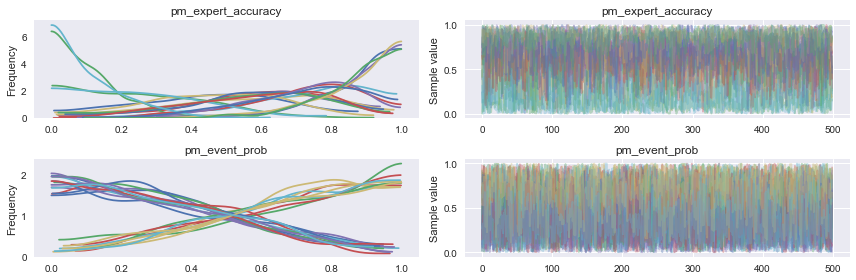

In [23]:
pm.traceplot(trace);

In [24]:
pm.summary(trace, varnames=['pm_event_prob'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pm_event_prob__0,0.334516,0.234341,0.005616,0.001579,0.785597,1000.0,0.999703
pm_event_prob__1,0.659468,0.249395,0.005381,0.178714,0.999624,1000.0,0.999005
pm_event_prob__2,0.665730,0.234433,0.005532,0.229925,0.999106,1000.0,0.999986
pm_event_prob__3,0.330839,0.230401,0.005938,0.000233,0.780003,1000.0,0.999174
pm_event_prob__4,0.678211,0.222111,0.005249,0.247898,0.999203,1000.0,1.000227
pm_event_prob__5,0.665844,0.232072,0.005061,0.226255,0.999462,1000.0,0.999135
pm_event_prob__6,0.346803,0.232810,0.005121,0.000206,0.781617,1000.0,0.999264
pm_event_prob__7,0.325158,0.222542,0.005214,0.003063,0.748143,1000.0,0.999337
pm_event_prob__8,0.334645,0.228372,0.004975,0.000429,0.759324,1000.0,0.999356
pm_event_prob__9,0.333840,0.240579,0.005490,0.000111,0.785329,1000.0,0.999347


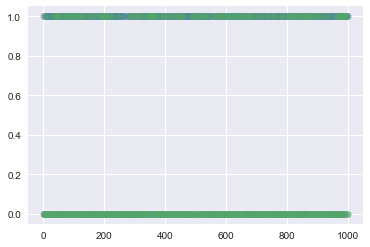

In [31]:
post_predi = np.random.binomial(p=trace['pm_event_prob'][:,10:], n=1)
plt.plot(post_predi, 'o', alpha=.25);